In [1]:
%matplotlib inline
import rebound
import numpy as np
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants
import math
Mj = 955e-6 #...Jupiter mass in Solar units



In [2]:
#---HD 147018---#
def setup_system():
    sim = rebound.Simulation()
    #sim.add(m=1.0)
    sim.add(m=0.927)
    sim.add(a=0.238900,e=0.468600,m=0.0,omega=66.0054*np.pi/180.0,inc=35.614629*np.pi/180,Omega=0.,M=0.698350*np.pi/180.0)
    #sim.add(a=0.238900,e=0.468600,m=0.00202983,omega=66.0054*np.pi/180.0,inc=35.614629*np.pi/180,Omega=0.,M=0.698350*np.pi/180.0)
    sim.add(a=1.9230,e=0.133000,m=0.0062886114,omega=136.865*np.pi/180.0,inc=3.3853710*np.pi/180,Omega=180.*np.pi/180.,M=-293.214*np.pi/180.0)
    #sim.move_to_com() # Moves to the center of momentum frame
    sim.move_to_hel()
    return sim


In [28]:
force_is_velocity_dependent = False
def tidal_evolution(reb_sim,rebx_effect,dt,timing):
    sim = reb_sim.contents
    f = sim.particles[1].f
    n = sim.particles[1].n
    e = sim.particles[1].e
    a = sim.particles[1].a
    i = sim.particles[1].inc
    Ω = sim.particles[1].Omega
    ω = sim.particles[1].omega
    idot = 0.
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    xdot = sim.particles[1].vx
    ydot = sim.particles[1].vy
    zdot = sim.particles[1].vz
    F0 = 1. - e**2.
    edot = -1.677e-21*e*((1. + (15./4.)*e**2. + (15./8.)*e**4. + (5./64.)*e**6.))/F0**(13./2.)
    adot = 2*a*e*edot/F0
    adotovera = 2*e*edot/F0
    r = a * F0 / (1. + e * math.cos(f))
    rdot = n * a * e * math.sin(f) * F0**(0.5)
    rfdot = n * a * (1. + e * math.cos(f)) * F0**(0.5)
    drde = -(2.*e*r) / F0 - (r**2. * math.cos(f)) / (a * F0)
    drdotde = rdot / (e * F0)
    drfdotde = rfdot*(e + math.cos(f))/(F0*(1. + e * math.cos(f)))
    F1 = drdotde * math.cos(ω+f) - drfdotde * math.sin(ω+f)
    F2 = drdotde * math.cos(i) * math.sin(ω+f) + drfdotde * math.cos(i) * math.cos(ω+f) - idot * drde * z / r
    F3 = (zdot + idot/i * z) * idot
    F4 = math.sin(i) * math.sin(ω+f)
    F5 = math.sin(i) * math.cos(ω+f)
    F6 = math.cos(i) * math.sin(ω+f)
    F7 = math.cos(i) * math.cos(ω+f)
    xdotdot = (-xdot + 3.*z*idot*math.sin(Ω))*adotovera/2. \
        + (math.cos(Ω)*F1 - math.sin(Ω)*F2)*edot \
        + math.sin(Ω)*F3
    ydotdot = (-ydot - 3.*z*idot*math.cos(Ω))*adotovera/2. \
        + (math.sin(Ω)*F1 + math.cos(Ω)*F2)*edot \
        - math.cos(Ω)*F3
    zdotdot = (-rdot/2./a * F4  - rfdot/2./a * F5 + r*idot/a * F6) * adot \
        + (drdotde*F4 + drfdotde*F5 + drde*idot*F6)*edot \
        + (rdot*F6 + rfdot*F7 + r*idot/i*F6 - idot*z)*idot
        
    sim.particles[1].ax += xdotdot
    sim.particles[1].ay += ydotdot
    sim.particles[1].az += zdotdot
    
    

In [42]:
def sim_integrate(sim,time_stop,Nout=1000,add_tidal_evolution=False,add_gr=False):
    sim.dt = sim.particles[1].P/60.
    sim.integrator = "mercurius"
    times = np.linspace(0.,2.*np.pi*time_stop,Nout)
    pomega1 = np.zeros(Nout)
    pomega2 = np.zeros(Nout)
    e1 = np.zeros(Nout) 
    inc1 = np.zeros(Nout)
    inc2 = np.zeros(Nout)
    Omega1 = np.zeros(Nout) 
    Omega2 = np.zeros(Nout) 

    if add_tidal_evolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(tidal_evolution2, force_is_velocity_dependent)
        
    if add_gr == True:
        rebx = reboundx.Extras(sim)
        #gr = rebx.add("gr")
        gr = rebx.add("gr_full")
        gr.params["c"] = constants.C
    
        
    for i,t in enumerate(times):
        sim.move_to_hel()
        sim.integrate(t,exact_finish_time=0)
        pomega1[i] = sim.particles[1].pomega
        pomega2[i] = sim.particles[2].pomega
        e1[i] = sim.particles[1].e
        inc1[i] = sim.particles[1].inc
        inc2[i] = sim.particles[2].inc
        Omega1[i] = sim.particles[1].Omega
        Omega2[i] = sim.particles[2].Omega
        #if i%10 == 0:
        #    print(str(int((i+1)/10)) + "%")
        
    times = times/(2.*np.pi)
    
    return np.array([times,pomega1,pomega2,e1,inc1,inc2,Omega1,Omega2])
    


In [30]:
#...Vector-addition of inclination
def vector_addition(data):
    times,pomega1,pomega2,e1,inc1,inc2,Omega1,Omega2 = data
    deltaOmega = Omega1-Omega2
    cosimut = np.cos(inc1)*np.cos(inc2)+np.sin(inc1)*np.sin(inc2)*np.cos(deltaOmega)
    imut = np.degrees(np.arccos(cosimut))
    deltapom = np.degrees(pomega2-pomega1+2*np.pi)%360.
    
    return np.array([deltapom,imut])


In [43]:
sim = setup_system()
data = sim_integrate(sim,0.05*1e6,add_gr=False)
sim = setup_system()
data_GR = sim_integrate(sim,0.05*1e6,add_gr=True)


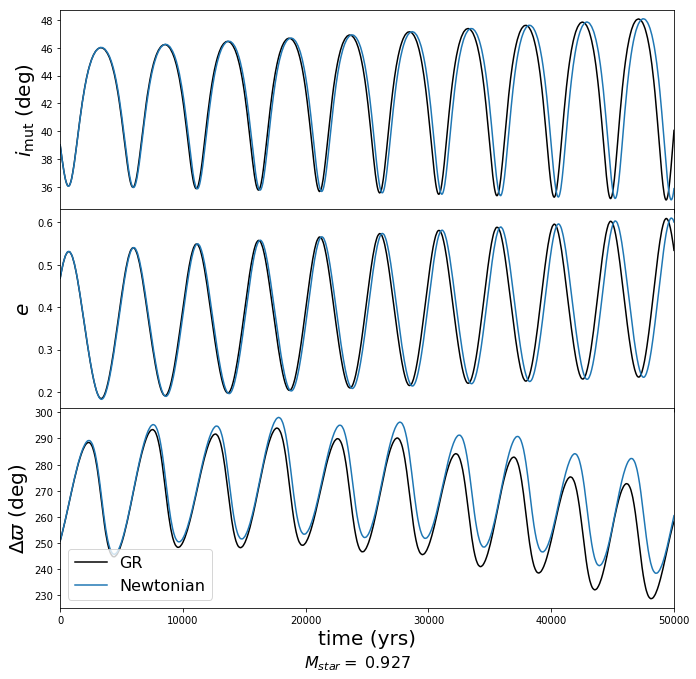

In [51]:
times,pomega1,pomega2,e1,inc1,inc2,Omega1,Omega2 = data
times_GR,pomega1_GR,pomega2_GR,e1_GR,inc1_GR,inc2_GR,Omega1_GR,Omega2_GR = data_GR
deltapom,imut = vector_addition(data)
deltapom_GR,imut_GR = vector_addition(data_GR)

txt = r'$M_{star} =$ '+str(Mstar)
Mstar = sim.particles[0].m
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True,figsize=(11,11)) 
plt.subplots_adjust(wspace=0, hspace=0)
ax = plt.gca()
ax.autoscale(enable=True, axis='x', tight=True)


#ax1.set_title(r'$M_{star} =$ '+str(Mstar),fontsize=20)
ax1.plot(times,imut_GR,color='black',label='GR')
ax1.plot(times,imut,label="Newtonian")
ax1.set_ylabel(r'$i_{\mathrm{mut}}$ (deg)',fontsize=20)

ax2.plot(times,e1_GR,color='black',label="GR")
ax2.plot(times,e1,label="Newtonian")
ax2.set_ylabel(r'$e$',fontsize=20)


ax3.plot(times,deltapom_GR,color='black',label="GR")
ax3.plot(times,deltapom,label="Newtonian")
ax3.set_ylabel(r'$\Delta\varpi$ (deg)',fontsize=20)
ax3.set_xlabel('time (yrs)',fontsize=20)
ax3.legend(loc="lower left",fontsize=16)

fig.text(.5, .05, txt, ha='center',fontsize=16)
move_to = 'frame-def'
savetag = 'plots/N-body_HD147018_Mstar-'+str(Mstar)+"_"+move_to
savetype = '.png'

#plt.savefig(savetag+savetype,dpi=300,bbox_inches="tight")

In [75]:
#---HD 147018---#

def setup_system2(e0,a0):
    sim = rebound.Simulation()
    sim.add(m=0.927)
    sim.add(a=a0,e=e0,m=0.00202983,omega=np.radians(66.0054),inc=np.radians(35.614629),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim


force_is_velocity_dependent = False
def tidal_evolution2(reb_sim,rebx_effect,dt,timing):
    sim = reb_sim.contents
    t = sim.t
    nyears = 2.*np.pi
    τ = 10.*nyears
    f = sim.particles[1].f
    n = sim.particles[1].n
    e = sim.particles[1].e
    a = sim.particles[1].a
    i = sim.particles[1].inc
    Ω = sim.particles[1].Omega
    ω = sim.particles[1].omega
    idot = 0.
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    xdot = sim.particles[1].vx
    ydot = sim.particles[1].vy
    zdot = sim.particles[1].vz
    F0 = 1. - e**2.
    #edot = -(e0/τ)*np.exp(-t/τ)
    edot = (2.*np.pi*e0/τ)*np.cos(2.*np.pi*t/τ)
    #adot = 2*a*e*edot/F0
    #adotovera = 2*e*edot/F0
    adot = 0.
    adotovera = 0.
    r = a * F0 / (1. + e * math.cos(f))
    rdot = n * a * e * math.sin(f) * F0**(0.5)
    rfdot = n * a * (1. + e * math.cos(f)) * F0**(0.5)
    drde = -(2.*e*r) / F0 - (r**2. * math.cos(f)) / (a * F0)
    drdotde = rdot / (e * F0)
    drfdotde = rfdot*(e + math.cos(f))/(F0*(1. + e * math.cos(f)))
    F1 = drdotde * math.cos(ω+f) - drfdotde * math.sin(ω+f)
    F2 = drdotde * math.cos(i) * math.sin(ω+f) + drfdotde * math.cos(i) * math.cos(ω+f) - idot * drde * z / r
    F3 = (zdot + idot/i * z) * idot
    F4 = math.sin(i) * math.sin(ω+f)
    F5 = math.sin(i) * math.cos(ω+f)
    F6 = math.cos(i) * math.sin(ω+f)
    F7 = math.cos(i) * math.cos(ω+f)
    xdotdot = (-xdot + 3.*z*idot*math.sin(Ω))*adotovera/2. \
        + (math.cos(Ω)*F1 - math.sin(Ω)*F2)*edot \
        + math.sin(Ω)*F3
    ydotdot = (-ydot - 3.*z*idot*math.cos(Ω))*adotovera/2. \
        + (math.sin(Ω)*F1 + math.cos(Ω)*F2)*edot \
        - math.cos(Ω)*F3
    zdotdot = (-rdot/2./a * F4  - rfdot/2./a * F5 + r*idot/a * F6) * adot \
        + (drdotde*F4 + drfdotde*F5 + drde*idot*F6)*edot \
        + (rdot*F6 + rfdot*F7 + r*idot/i*F6 - idot*z)*idot
        
    sim.particles[1].ax += xdotdot
    sim.particles[1].ay += ydotdot
    sim.particles[1].az += zdotdot
    
#...Newtownian integration
year = 2.*np.pi # One year in units where G=1
def sim_integrate2(sim,time_stop,Nout=100,add_tidal_evolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 
    a = np.zeros(Nout)

    if add_tidal_evolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(tidal_evolution2, force_is_velocity_dependent)
        
    for i,t in enumerate(times):
        sim.integrate(t)
        e[i] = sim.particles[1].e
        a[i] = sim.particles[1].a
    times = times/(2.*np.pi)  
    return np.array([times,e,a])



In [33]:
def eEvol(e0,t,τ,evolType:str):
    if evolType == 'exp':
        e = e0*np.exp(-t/τ)
    elif evolType == 'trig':
        e = e0*(np.sin(2.*np.pi*t/τ) + 1)
    elif evolType == 'const':
        e = e0 * np.ones(len(t))
    return e

In [76]:
e0 = 0.468600
a0 = 0.238900
τ = 10.
t_stop = τ
sim = setup_system2(e0,a0)
data = sim_integrate2(sim,t_stop,add_tidal_evolution=True)
times,e,a = data


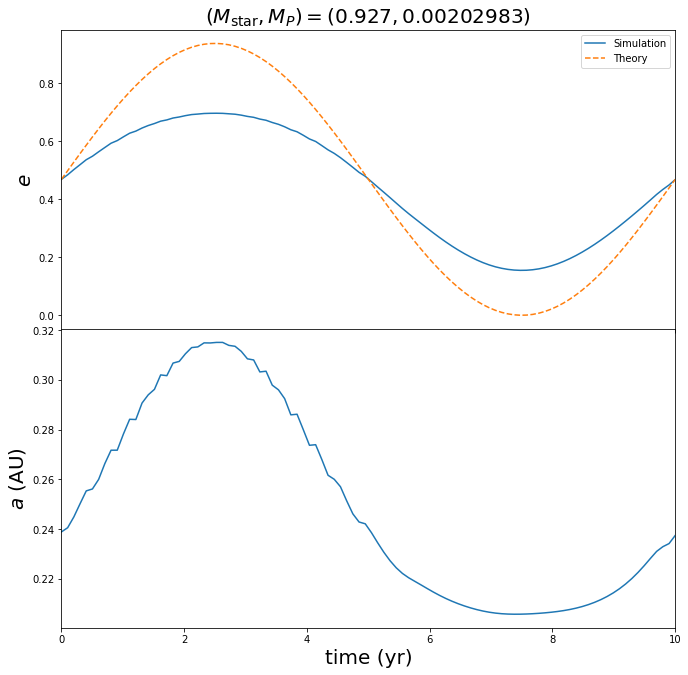

In [79]:
Mstar = sim.particles[0].m
Mp = sim.particles[1].m

ecc = eEvol(e0,times,τ,'trig')
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True,figsize=(11,11)) 
plt.subplots_adjust(wspace=0, hspace=0)
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)

ax1.set_title(r'$(M_{\mathrm{star}},M_{P})=($'+str(Mstar)+'$,$'+str(Mp)+'$)$',fontsize=20)
ax1.plot(times,e,label='Simulation')
ax1.set_ylabel(r'$e$ ',fontsize=20)
ax1.plot(times,ecc,'--',label='Theory')
#ax1.set_ylim(e0*0.9,e0*1.1)
#ax1.axhline(y=1,color='black')
#ax1.axvline(x=5,color='black')
ax1.legend()

ax2.plot(times,a)
ax2.set_ylabel(r'$a$ (AU)',fontsize=20)
ax2.set_xlabel('time (yr)', fontsize=20)
#ax2.set_ylim(a0*0.9,a0*1.1);

plt.legend()

savetag = 'eEvol_exp'
savetype = '.png'

plt.savefig('plots/'+savetag+savetype,dpi=300,bbox_inches='tight')

In [58]:
sim = setup_system2(e0,a0)

In [60]:
a = sim.particles[1].a
year = np.sqrt(4.*np.pi*a**3./(sim.particles[0].m))

In [61]:
year

0.42992162395371869

In [62]:
sim.particles[1].P

0.7611833211018063